## **HW1 Análisis Predictivo: Predicción Ingresos Apple**
##Álvaro Payo Bastante

In [ ]:
%%shell
jupyter nbconvert --to html //

[NbConvertApp] Converting notebook ///content/HW1_Analisis_Predictivo_Alvaro_Payo.ipynb to html
[NbConvertApp] Writing 956022 bytes to ///content/HW1_Analisis_Predictivo_Alvaro_Payo.html


##**1. Importar librerías y datos**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#En primer lugar, importo los datos. Para que sea más cómodo manipularlos, renombro las columnas, elimino la de 'Trimestre' ya que no
#aporta información, y pongo la columna 'Fecha' en formato fecha y como índice.
df = pd.read_csv('/content/drive/MyDrive/Análisis predictivo/aapl.csv', sep=';')
df.columns = ['Trimestre', 'Fecha', 'Ingresos']
df = df.drop(['Trimestre'], axis=1)
df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.set_index('Fecha')
df.head(10)

,Ingresos
Fecha,
1989-12-29,"1493,4"
1990-03-30,"1346,2"
1990-06-29,"1364,8"
1990-09-28,"1354,1"
1990-12-28,"1675,5"
1991-03-29,"1597,7"
1991-06-28,"1528,6"
1991-09-27,"1507,1"
1991-12-27,"1862,6"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 1989-12-29 to 2021-06-26
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Ingresos  127 non-null    object
dtypes: object(1)
memory usage: 2.0+ KB


In [6]:
#Al ser la columna 'Ingresos' tipo object, reemplazo las comas por puntos y la transformo a float. 
#Esto es debido a que contiene datos que quiero tratar como números.
df['Ingresos'] = df['Ingresos'].apply(lambda x: x.replace(',','.'))
df['Ingresos'] = df['Ingresos'].astype(float)
df

,Ingresos
Fecha,
1989-12-29,1493.4
1990-03-30,1346.2
1990-06-29,1364.8
1990-09-28,1354.1
1990-12-28,1675.5
...,...
2020-06-27,59685.0
2020-09-26,64698.0
2020-12-26,111439.0


In [7]:
#Pongo los datos como trimestrales.
df_ts = df.resample("q").last()
df.tail()

,Ingresos
Fecha,
2020-06-27,59685.0
2020-09-26,64698.0
2020-12-26,111439.0
2021-03-27,89584.0
2021-06-26,81434.0


In [8]:
#Al realizar el paso anterior, hay 5 NA's.
df_ts.isnull().sum()

Ingresos    5
dtype: int64

In [9]:
#Para solucionar el problema de los NA's, imputo manualmente los datos faltantes, además de imputar los años con desfase temporal.
df_ts.loc['1994-06-30', 'Ingresos']= 2149.9
df_ts.loc['1999-12-31', 'Ingresos']= 2343.0
df_ts.loc['2000-03-31', 'Ingresos']= 1945.0
df_ts.loc['2000-06-30', 'Ingresos']= 1825.0
df_ts.loc['2005-09-30', 'Ingresos']= (3520.0+5749.0)/2 #Media entre el segundo y el cuarto trimestre de 2005
df_ts.loc['2006-03-31', 'Ingresos']= 4359.0
df_ts.loc['2006-06-30', 'Ingresos']= 4370.0
df_ts.loc['2017-03-31', 'Ingresos']= 52896.0
df_ts.loc['2017-06-30', 'Ingresos']= 45408.0

### sktime

In [1]:
!pip install sktime[all_extras]
import sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **2. Gráfico de los ingresos y comportamiento estacional**

### 2.1. Gráfico de los ingresos

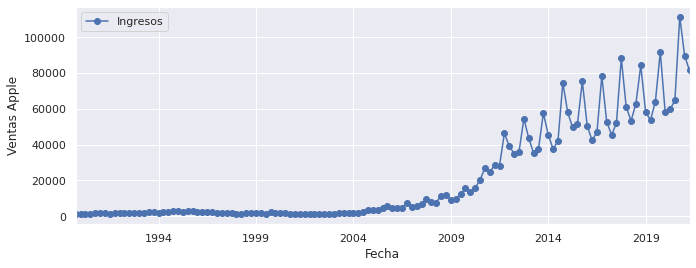

In [10]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})
ax = df_ts.plot(marker='o', linestyle='-')
ax.set_ylabel('Ventas Apple');

Los ingresos de Apple han ido aumentado significativamente a partir de 2009. Podemos ver como **la tendencia es creciente** y cada vez hay subidas y bajadas más pronunciadas. 

### 2.1. Comportamiento estacional

Text(0.5, 1.0, 'Comportamiento Estacional')

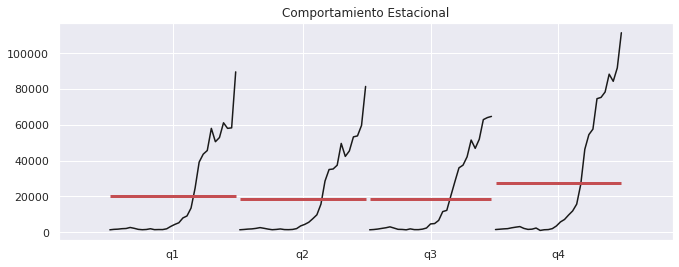

In [11]:
import statsmodels.api as sm
ax = plt.gca()
sm.graphics.tsa.quarter_plot(df_ts['Ingresos'],ax=ax)
ax.set_title('Comportamiento Estacional')

Se producen más ventas en el cuatro cuatrimestre. Esto es debido a que en ese periodo se encuentra la navidad y es cuando Apple suele lanzar sus nuevos productos. **Esto implica que hay estacionalidad.**

Al haber tendencia y estacionalidad, **los ingresos no son estacionarios ni en media ni en varianza.**

## **3. Ventas anuales y crecimientos anuales de los ingresos**

### 3.1. Ventas anuales 

In [12]:
#Utilizo el DataFrame con los NA's imputados manualmente y dividido en trimestres para dividirlo en años, sumando los trimestres
#de cada año. 
Ventas_anuales = pd.DataFrame(df_ts['Ingresos'].resample('Y').sum())

In [13]:
#He decidido quedarme con las ventas anuales de los últimos 8 años, ya que creo que es periodo suficiente para sacar conclusiones.
Ventas_anuales_14_21 = Ventas_anuales.tail(8)
Ventas_anuales_14_21

,Ingresos
Fecha,
2014-12-31,199800.0
2015-12-31,234440.0
2016-12-31,218118.0
2017-12-31,238536.0
2018-12-31,261612.0
2019-12-31,267683.0
2020-12-31,294135.0
2021-12-31,171018.0


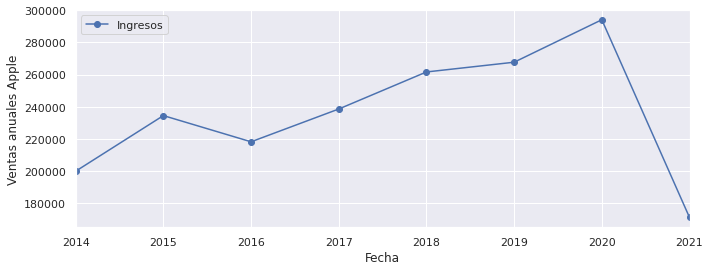

In [14]:
#Gráfico de las ventas anuales de Apple desde 2014
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})
ax = Ventas_anuales_14_21.plot(marker='o', linestyle='-')
ax.set_ylabel('Ventas anuales Apple');

Exceptuando una pequeña bajada en 2016, se puede apreciar una **tendencia positiva** en las ventas anuales de Apple desde 2014.

La bajada en el gráfico en el año 2021 es debido a que nuestros datos solo llegan hasta el segundo trimestre de 2021, por lo que **las ventas de la segunda parte de 2021 no están contabilizadas todavía.**

### 3.2. Crecimientos anuales de los ingresos

In [15]:
Crecimiento = [] 
  
for i in range(1, len(Ventas_anuales['Ingresos'])): 
    Crecimiento.append(Ventas_anuales['Ingresos'][i] - Ventas_anuales['Ingresos'][i-1]) 
  
Crecimiento.insert(0, 0)

In [16]:
Crecimientos_anuales = pd.DataFrame()

Crecimientos_anuales['Ingresos'] = Ventas_anuales['Ingresos']
Crecimientos_anuales["Crecimiento"] = Crecimiento

In [17]:
Crecimientos_anuales_14_21 = Crecimientos_anuales.tail(8)
Crecimientos_anuales_14_21

,Ingresos,Crecimiento
Fecha,,
2014-12-31,199800.0,25808.0
2015-12-31,234440.0,34640.0
2016-12-31,218118.0,-16322.0
2017-12-31,238536.0,20418.0
2018-12-31,261612.0,23076.0
2019-12-31,267683.0,6071.0
2020-12-31,294135.0,26452.0
2021-12-31,171018.0,-123117.0


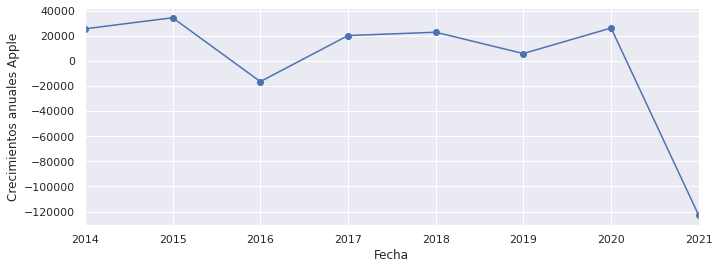

In [18]:
#Gráfico de los crecimientos anuales de Apple desde 2014
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})
ax = Crecimientos_anuales_14_21['Crecimiento'].plot(marker='o', linestyle='-')
ax.set_ylabel('Crecimientos anuales Apple');

Los ingresos **crecen anualmente todos los años desde 2014** excepto en el año 2016, y en **el año 2021 falta medio año de ingresos por contabilizar.**

También se puede apreciar que en el año 2019 hay otra bajada en el gráfico. Esto se debe a que en 2019 los ingresos crecen menos que en 2018 y que en 2020. Por lo tanto, no es que no crezca respecto al año anterior, sino que el crecimiento es menor al año anterior y posterior.

## **4. Aplicar la estimación y selección de modelos ETS**

In [19]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split

119 8


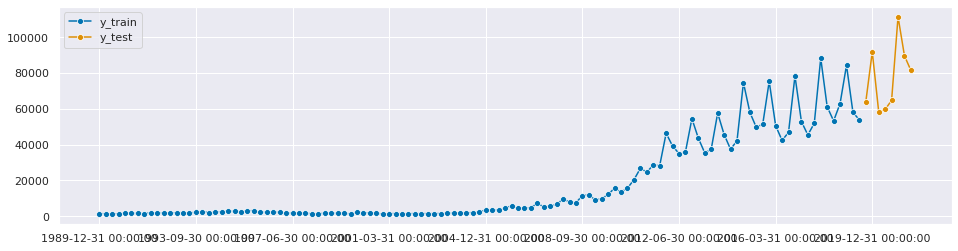

In [20]:
#Divido los datos en train y test. Test son los 8 últimos componentes de los datos.
y_train, y_test = temporal_train_test_split(y = df_ts, test_size=8)

plot_series(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [21]:
from sktime.forecasting.ets import AutoETS
fh = np.arange(1, 9) 

df_auto_model = AutoETS(auto=True, sp=4, n_jobs=-1) 

In [22]:
df_auto_model.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=4)

In [23]:
print(df_auto_model.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  119
Model:                       ETS(MAM)   Log Likelihood                -968.824
Date:                Tue, 11 Oct 2022   AIC                           1957.649
Time:                        09:08:44   BIC                           1985.440
Sample:                    12-31-1989   HQIC                          1968.934
                         - 06-30-2019   Scale                            0.018
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4356      0.055      7.864      0.000       0.327       0.544
smoothing_trend        0.1662      0.035      4.750      0.000       0.098       0.235
smoothing_seasonal  

In [24]:
df_pred = df_auto_model.predict(fh)
print(df_pred)

                Ingresos
2019-09-30  58602.868363
2019-12-31  86146.872815
2020-03-31  59953.428416
2020-06-30  53254.307619
2020-09-30  58545.873359
2020-12-31  86063.069144
2021-03-31  59895.091538
2021-06-30  53202.476623


He estimado 8 trimestres con los datos de train, es decir, dejando fuera los últimos 8 trimestres (ya que estos ahora forman parte de test). 

Podemos ver que **las predicciones siguen en la línea de los años anteriores**, en los que se incrementan las ventas en el último cuatrimestre, mientras que en el resto son parecidas.

In [25]:
df_pred_ints = df_auto_model.predict_interval(fh, coverage=0.9)
df_pred_ints

Coverage               
                     0.9               
                   lower          upper
2019-09-30  46413.858587   71365.608163
2019-12-31  65305.460765  107221.004414
2020-03-31  42738.600080   79264.110719
2020-06-30  34852.168402   75048.205174
2020-09-30  33434.283782   89743.699570
2020-12-31  44021.504278  137529.088385
2021-03-31  26561.110159  103295.735451
2021-06-30  19414.143797   96677.709716

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

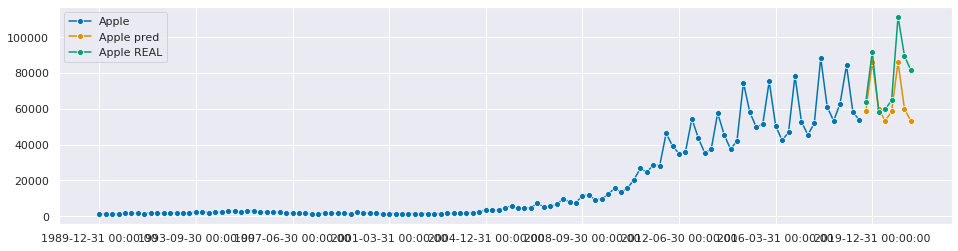

In [26]:
plot_series(y_train, df_pred, y_test, labels=["Apple", "Apple pred", "Apple REAL"])

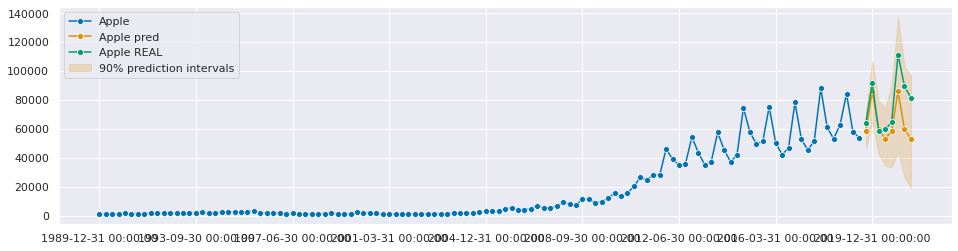

In [27]:
fig, ax = plot_series(y_train, df_pred, y_test, labels=["Apple", "Apple pred", "Apple REAL"])
ax.fill_between(
    ax.get_lines()[-2].get_xdata(),
    df_pred_ints[('Coverage', 0.9, 'lower')],
    df_pred_ints[('Coverage', 0.9, 'upper')],
    alpha=0.2,
    color=ax.get_lines()[-2].get_c(),
    label=f"90% prediction intervals",
)
ax.legend(loc='upper left')

Estos dos últimos gráficos muestran la predicción y los resultados reales. Además, el último gráfico incluye un área con los intervalos de confianza al 90%.

Podemos ver que **las predicciones y los resultados reales se encuentran dentro del área de confianza**, y que **los resultados reales han sido más favorables a Apple que lo que decían las predicciones.**

### **4.1. Precisión de las predicciones ETS**

In [28]:
#1. Mean Absolute Percentage Error (MAPE)
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, df_pred[0:8])

0.16043027812621546

In [29]:
#2. Mean Squared Error (MSE)
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError() 
mse(y_test, df_pred[0:8])

308252120.50046146

In [30]:
#3. Root Mean Square Error (RMSE)
rmse = MeanSquaredError(square_root=True)
rmse(y_test, df_pred[0:8])

17557.11025483583

### **4.2. Predicción 2021 y 2022 ETS**

Tras predecir las ventas hasta el segundo trimestre de 2021 sobre y_train, es decir, dejando fuera de la estimación los últimos 8 trimestres, procedo a estimar el modelo con todos los datos y a predecir las ventas de lo que queda de 2021 y de 2022.

In [31]:
fh2 = np.arange(1, 7) #6 trimestres (Q3 y Q4 de 2021 y Q1-Q4 de 2022)

df_auto_model1 = AutoETS(auto=True, sp=4, n_jobs=-1)

y = df_ts

df_auto_model1.fit(y) #ahora en vez del train, todos los datos

print(df_auto_model1.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  127
Model:                       ETS(MAM)   Log Likelihood               -1053.075
Date:                Tue, 11 Oct 2022   AIC                           2126.149
Time:                        09:09:19   BIC                           2154.591
Sample:                    12-31-1989   HQIC                          2137.705
                         - 06-30-2021   Scale                            0.018
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4425      0.056      7.938      0.000       0.333       0.552
smoothing_trend        0.1690      0.035      4.813      0.000       0.100       0.238
smoothing_seasonal  

In [32]:
df_pred1 = df_auto_model1.predict(fh2)
df_pred1

,Ingresos
2021-09-30,94832.409459
2021-12-31,153411.109909
2022-03-31,111544.558509
2022-06-30,103909.031926
2022-09-30,119678.250596
2022-12-31,191133.616729


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

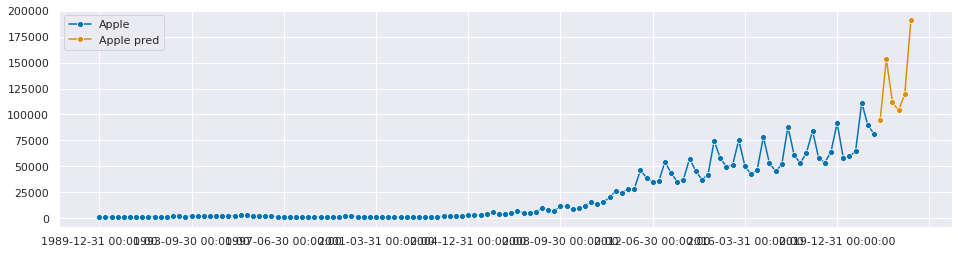

In [33]:
plot_series(y, df_pred1, labels=["Apple", "Apple pred"])

Tras estimar lo que queda de 2021 y 2022 con ETS, se puede ver que **las predicciones son bastante optimistas en comparación con datos pasados.**

Aunque el cuarto trimestre sigue siendo el más destacado, las predicciones estiman que **el nivel de ventas en general se elevaría considerablemente.**

## **5. Aplicar la estimación y selección de modelos ARIMA**

Una vez realizadas las predicciones de las ventas de Apple con el modelo ETS, procedo a realizar lo mismo con el modelo ARIMA, para más tarde comparar ambos modelos y elegir cual es el que predice mejor.

In [34]:
from sktime.transformations.series.boxcox import LogTransformer

In [35]:
#Transformación de los datos a logaritmos.
transformer = LogTransformer()
log_df_ts= transformer.fit_transform(df_ts)
log_df_ts.tail()

,Ingresos
2020-06-30,10.996836
2020-09-30,11.077486
2020-12-31,11.621233
2021-03-31,11.402932
2021-06-30,11.307548


Text(0.5, 1.0, 'Ventas Apple: Transformación LOG')

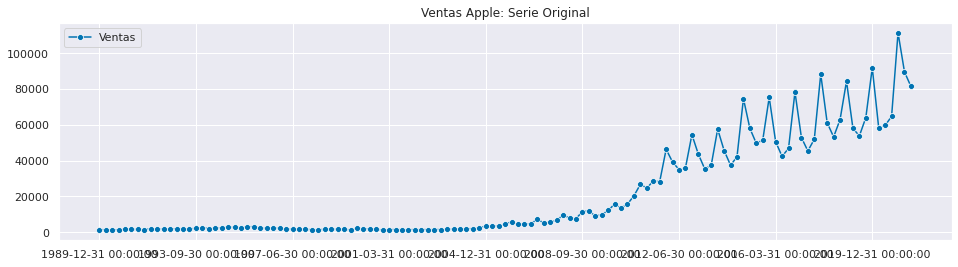

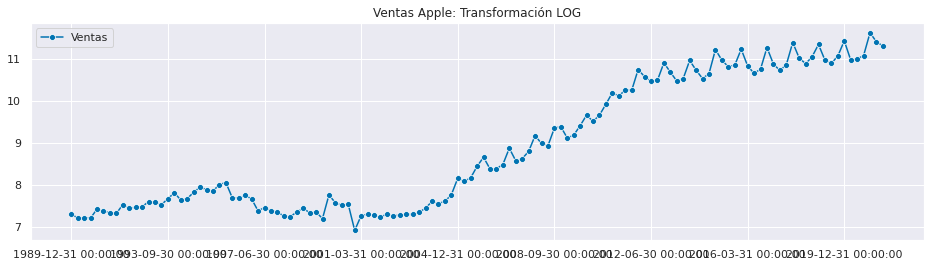

In [36]:
#Comparación gráfico con datos originales vs gráfico con datos transformados a logaritmos.
fig, ax =plot_series(df_ts, labels=["Ventas"])
ax.set_title('Ventas Apple: Serie Original')
fig, ax =plot_series(log_df_ts, labels=["Ventas"])
ax.set_title('Ventas Apple: Transformación LOG')

En el gráfico con los datos transformados a logaritmos se puede apreciar una **mayor precisión** a la hora de mostrar las variaciones de las ventas a lo largo de los años. 

Además, **las variaciones en los últimos años no son tan pronunciadas** como las de los datos originales.



In [37]:
#Autocorrelación de la serie en logaritmos
from sktime.utils.plotting import plot_correlations

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

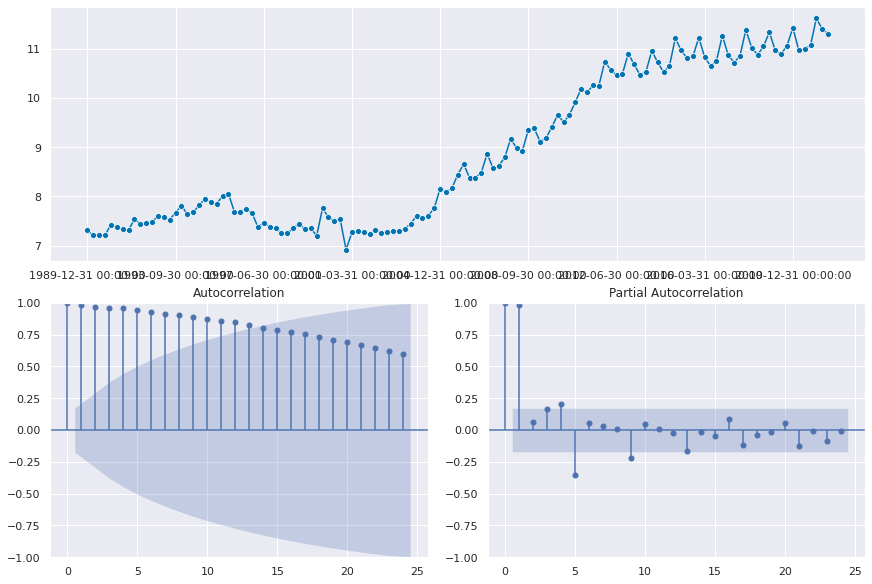

In [38]:
plot_correlations(log_df_ts)

In [39]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

119 8


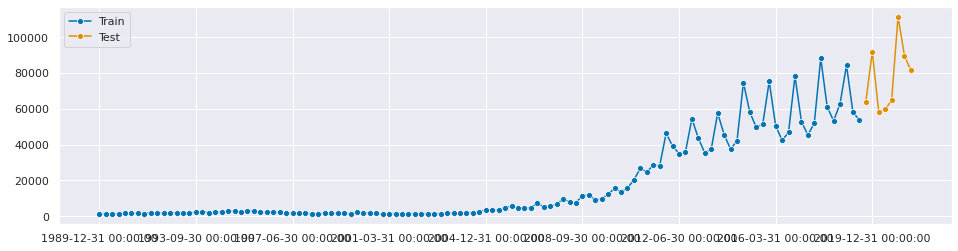

In [40]:
#Divido los datos transformados a logaritmos en train y test. Test son los 8 últimos componentes de los datos.
log_y_train, log_y_test = temporal_train_test_split(y = log_df_ts, test_size = 8)
plot_series(y_train, y_test, labels=["Train", "Test"])

print(y_train.shape[0], y_test.shape[0])

In [41]:
fh3 = np.arange(len(y_test)) + 1 
fh3

array([1, 2, 3, 4, 5, 6, 7, 8])

In [42]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=4,suppress_warnings=True)
forecaster.fit(log_y_train)

AutoARIMA(sp=4, suppress_warnings=True)

In [43]:
print(forecaster.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  119
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 4)   Log Likelihood                  57.858
Date:                           Tue, 11 Oct 2022   AIC                           -107.715
Time:                                   09:10:28   BIC                            -96.632
Sample:                               12-31-1989   HQIC                          -103.215
                                    - 06-30-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3100      0.083     -3.732      0.000      -0.473      -0.147
ar.S.L4        0.9275      0.060     15.421

In [44]:
log_y_pred = forecaster.predict(fh3)
log_y_pred

,Ingresos
2019-09-30,11.002482
2019-12-31,11.343003
2020-03-31,11.032804
2020-06-30,10.936526
2020-09-30,11.040886
2020-12-31,11.356735
2021-03-31,11.069011
2021-06-30,10.979709


In [45]:
np.exp(log_y_pred)

,Ingresos
2019-09-30,60022.956910
2019-12-31,84373.062788
2020-03-31,61870.821737
2020-06-30,56191.803343
2020-09-30,62372.910753
2020-12-31,85539.619022
2021-03-31,64152.027193
2021-06-30,58671.478165


He estimado 8 trimestres con los datos transformados a logaritmo de train(dejando fuera los últimos 8 trimestres, ya que estos ahora forman parte de test). 

Podemos ver que **las predicciones siguen en la línea de los años anteriores**, en los que se incrementan las ventas en el último cuatrimestre, mientras que en el resto son parecidas.

Además, **hay una menor diferencia entre el cuarto trimestre y el resto de los trimestres respecto al modelo ETS**, ya que las ventas en el resto de trimestres están más cerca de 60.000 que de 50.000, a diferencia de lo que pasaba anteriormente, en donde se encontraban más cerca de 50.000

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

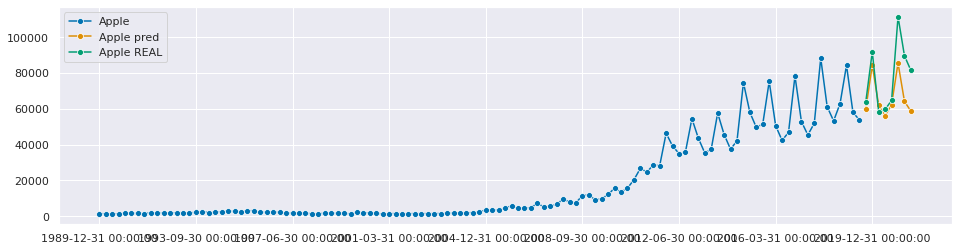

In [46]:
plot_series(y_train, np.exp(log_y_pred),y_test, labels=["Apple", "Apple pred", "Apple REAL"])

Este gráfico muestra la predicción y los resultados reales. 

Podemos ver que **los resultados reales han sido más favorables a Apple que lo que decían las predicciones.**

### **5.1. Precisión de las predicciones ARIMA**

In [47]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError

In [48]:
#1a. Mean Absolute Percentage Error (MAPE)
mean_absolute_percentage_error(log_y_test, log_y_pred)

0.013559466794007229

In [49]:
#1b. Mean Absolute Percentage Error (MAPE) -> Original Time Serie
mean_absolute_percentage_error(y_test, np.exp(log_y_pred))

0.13688967453830286

In [50]:
#2a. Mean Squared Error (MSE)
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError() 
mse(log_y_test, log_y_pred)

0.038596730747029025

In [51]:
#2b. Mean Squared Error (MSE) -> Original Time Serie
from sktime.performance_metrics.forecasting import MeanSquaredError
mse = MeanSquaredError() 
mse(log_y_test, np.exp(log_y_pred))

4557538522.544778

In [52]:
#3a. Root Mean Square Error (RMSE)
rmse = MeanSquaredError(square_root=True)
rmse(log_y_test, log_y_pred)

0.1964605068379623

In [53]:
#3b. Root Mean Square Error (RMSE) -> Original Time Serie
rmse = MeanSquaredError(square_root=True)
rmse(y_test, np.exp(log_y_pred))

15562.538155631677

### **5.2. Predicción 2021 y 2022 ARIMA**

Tras predecir las ventas hasta el segundo trimestre de 2021 sobre y_train con los datos transformados a logaritmo y dejando fuera de la estimación los últimos 8 trimestres, procedo a estimar el modelo con todos los datos y a predecir las ventas de lo que queda de 2021 y de 2022.

In [54]:
fh4 = np.arange(6) + 1  #6 trimestres (Q3 y Q4 de 2021 y Q1-Q4 de 2022)
fh4

array([1, 2, 3, 4, 5, 6])

In [55]:
forecaster = AutoARIMA(sp=4,suppress_warnings=True)
forecaster.fit(log_df_ts) #ahora sobre todos los datos, no solo sobre y_train

AutoARIMA(sp=4, suppress_warnings=True)

In [56]:
print(forecaster.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  127
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 4)   Log Likelihood                  63.352
Date:                           Tue, 11 Oct 2022   AIC                           -118.704
Time:                                   09:11:32   BIC                           -107.358
Sample:                               12-31-1989   HQIC                          -114.094
                                    - 06-30-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2981      0.077     -3.870      0.000      -0.449      -0.147
ar.S.L4        0.9420      0.049     19.169

In [57]:
log_y_pred2 = forecaster.predict(fh4)
log_y_pred2

,Ingresos
2021-09-30,11.409148
2021-12-31,11.806064
2022-03-31,11.526863
2022-06-30,11.463973
2022-09-30,11.561122
2022-12-31,11.935032


In [58]:
np.exp(log_y_pred2)

,Ingresos
2021-09-30,90142.546061
2021-12-31,134062.902398
2022-03-31,101403.525263
2022-06-30,95222.603261
2022-09-30,104937.733005
2022-12-31,152517.126124


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

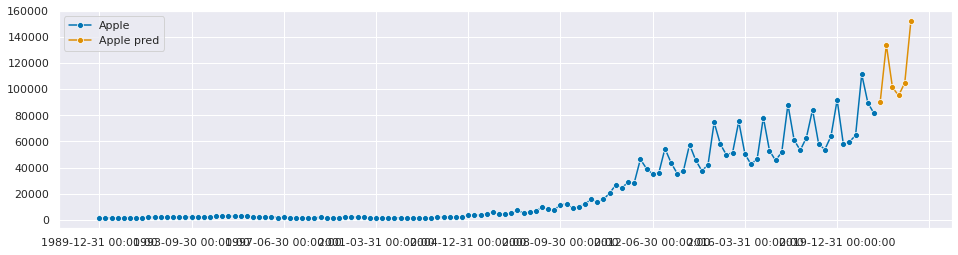

In [59]:
plot_series(df_ts, np.exp(log_y_pred2), labels=["Apple", "Apple pred"])

Tras estimar lo que queda de 2021 y 2022 con ETS, se puede ver que **las predicciones son bastante optimistas en comparación con datos pasados.**

Aunque el cuarto trimestre sigue siendo el más destacado, las predicciones estiman que **el nivel de ventas en general se elevaría considerablemente.**

Además, cabe destacar que aunque **las predicciones** son superiores a los datos pasados, estas **son menores que las del modelo ETS**. Es decir, que las predicciones del modelo ARIMA, en principio, **se ajustan más a la realidad ya que no se alejan tanto de los datos pasados.**

## **6. Comparación de las predicciones de los dos modelos**

### 6.1. Métricas

In [60]:
Metricas_comparacion_ETS_ARIMA = pd.DataFrame()

ETS = {'MAPE': '0.16043027812621546', 'MSE': '308252120.50046146', 'RMSE': '17557.11025483583'}
ARIMA_Datos_Originales = {'MAPE': '0.13688967453830286', 'MSE': '4557538522.544778', 'RMSE': '15562.538155631677'}
ARIMA_Logaritmos = {'MAPE': '0.013559466794007229', 'MSE': '0.038596730747029025', 'RMSE': '0.1964605068379623'}

Metricas_comparacion_ETS_ARIMA = Metricas_comparacion_ETS_ARIMA.append(ETS, ignore_index=True)
Metricas_comparacion_ETS_ARIMA = Metricas_comparacion_ETS_ARIMA.append(ARIMA_Datos_Originales, ignore_index=True)
Metricas_comparacion_ETS_ARIMA = Metricas_comparacion_ETS_ARIMA.append(ARIMA_Logaritmos, ignore_index=True)

Modelos = ["ETS", "ARIMA_Datos_Originales", "ARIMA_Logaritmos"]

Metricas_comparacion_ETS_ARIMA['Modelos'] = Modelos
Metricas_comparacion_ETS_ARIMA.set_index('Modelos', inplace = True)

Metricas_comparacion_ETS_ARIMA

,MAPE,MSE,RMSE
Modelos,,,
ETS,0.16043027812621546,308252120.50046146,17557.11025483583
ARIMA_Datos_Originales,0.13688967453830286,4557538522.544778,15562.538155631677
ARIMA_Logaritmos,0.013559466794007229,0.038596730747029025,0.1964605068379623


Para comparar las predicciones de los modelos, voy a empezar comentando sus métricas.

Respecto al **MAPE**, aunque ambos son buenos ya que se encuentran por debajo del 20%, el de **ARIMA** es mejor (el error medio es más bajo).

Respecto al **RMSE**, también es mejor el de **ARIMA** ya que es más bajo y por lo tanto sus predicciones se acercan más a la realidad, es decir, más cercanos son los valores predichos y observados.

### 6.2. 2021 y 2022

In [ ]:
#ETS

In [61]:
#Predicciones ETS
df_pred1 = df_auto_model1.predict(fh2)
df_pred1

,Ingresos
2021-09-30,94832.409459
2021-12-31,153411.109909
2022-03-31,111544.558509
2022-06-30,103909.031926
2022-09-30,119678.250596
2022-12-31,191133.616729


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

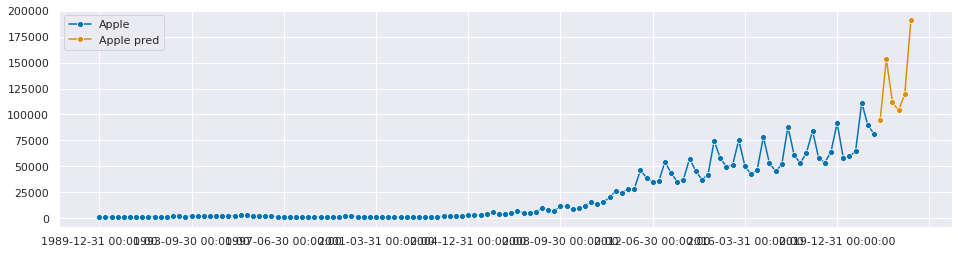

In [62]:
#Gráfico predicciones ETS
plot_series(y, df_pred1, labels=["Apple", "Apple pred"])

In [ ]:
#ARIMA

In [63]:
#Predicciones ARIMA
np.exp(log_y_pred2)

,Ingresos
2021-09-30,90142.546061
2021-12-31,134062.902398
2022-03-31,101403.525263
2022-06-30,95222.603261
2022-09-30,104937.733005
2022-12-31,152517.126124


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

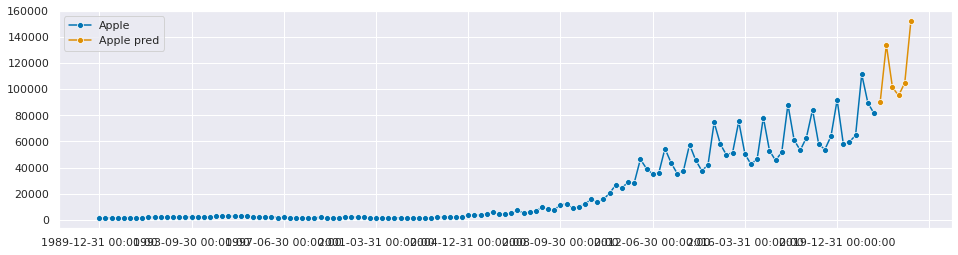

In [64]:
#Gráfico predicciones ARIMA
plot_series(df_ts, np.exp(log_y_pred2), labels=["Apple", "Apple pred"])

Como he comentado anteriormente, l**as predicciones de ETS son más optimistas** ya que preven unas ventas superiores que las de ARIMA, aunque ambas predicciones se encuentran por encima de los datos pasados. Por ello, podemos decir que **es mejor el modelo ARIMA ya que se acerca más a la realidad**, como también he comentado en el apartado anterior sobre las métricas.

### 6.3. ¿Qué modelo predice mejor?

Podemos concluir que **el modelo ARIMA** predice mejor ya que obtiene mejores métricas y se acerca más a la realidad. 

## **7. ¿Existe efecto COVID? Cuantificar.**

In [76]:
#Predicciones ARIMA. 
ARIMA_COVID = np.exp(log_y_pred)

In [77]:
#Ventas reales
Reales_COVID = df_ts.tail(8)

In [86]:
Efecto_COVID = pd.DataFrame()

Efecto_COVID['Reales'] = Reales_COVID['Ingresos'].astype(float)
Efecto_COVID['ARIMA'] = ARIMA_COVID['Ingresos'].astype(float)
Efecto_COVID['Efecto COVID'] = Efecto_COVID['Reales'] - Efecto_COVID['ARIMA'] 

Efecto_COVID

,Reales,ARIMA,Efecto COVID
2019-09-30,64040.0,60022.956910,4017.043090
2019-12-31,91819.0,84373.062788,7445.937212
2020-03-31,58313.0,61870.821737,-3557.821737
2020-06-30,59685.0,56191.803343,3493.196657
2020-09-30,64698.0,62372.910753,2325.089247
2020-12-31,111439.0,85539.619022,25899.380978
2021-03-31,89584.0,64152.027193,25431.972807
2021-06-30,81434.0,58671.478165,22762.521835


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

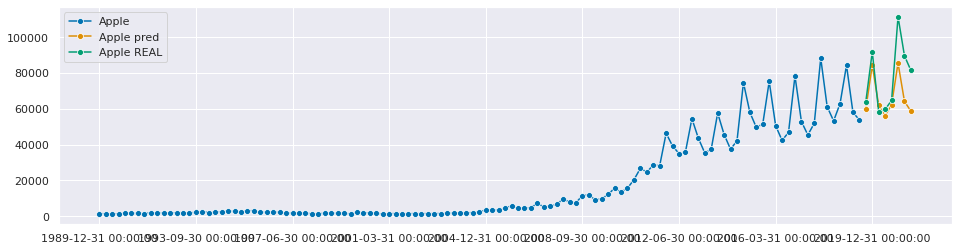

In [73]:
plot_series(y_train, np.exp(log_y_pred),y_test, labels=["Apple", "Apple pred", "Apple REAL"])

Para cuantificar el efecto COVID he optado por ver **la diferencia entre las ventas reales de Apple y las predicciones de ventas de ARIMA en los últimos 8 trimestres.**

Como todos sabemos, el COVID llegó a nuestras vidas a principios de 2020. Podemos ver como, según iba haciéndose más presente, más incrementan las ventas reales y más diferencia hay con las predicciones. 

**La diferencia es notable a partir del cuarto trimestre de 2020**, donde las ventas reales superan en más de 20.000 a las predicciones.

Además, también podemos verlo en el gráfico, donde la línea verde (Apple Real) está por encima de la línea naranja (predicciones ARIMA), sobretodo a partir del cuarto cuatrimestre de 2020.



## **8. Ventas acumuladas 2021 y 2022**

### 8.1. Ventas acumuladas 2021

In [65]:
resto_2021_y_2022 = np.exp(log_y_pred2)

In [66]:
primera_mitad_2021 = df_ts.tail(2)
primera_mitad_2021

,Ingresos
2021-03-31,89584.0
2021-06-30,81434.0


In [67]:
segunda_mitad_2021 = resto_2021_y_2022.head(2)
segunda_mitad_2021

,Ingresos
2021-09-30,90142.546061
2021-12-31,134062.902398


In [68]:
Ventas2021 = pd.DataFrame()

Fechas = ['2021-03-31', '2021-06-30', '2021-09-30', '2021-03-31']
Ingresos = [89584.0, 81434.0, 90142.546061, 134062.902398]

Ventas2021['Fechas'] = Fechas
Ventas2021['Ingresos'] = Ingresos

Ventas2021['Fechas'] = pd.to_datetime(Ventas2021['Fechas'])
Ventas2021 = Ventas2021.set_index('Fechas')

Ventas2021

,Ingresos
Fechas,
2021-03-31,89584.000000
2021-06-30,81434.000000
2021-09-30,90142.546061
2021-03-31,134062.902398


In [69]:
Ventas_2021 = pd.DataFrame(Ventas2021['Ingresos'].resample('Y').sum())
Ventas_2021

,Ingresos
Fechas,
2021-12-31,395223.448459


### 8.2. Ventas acumuladas 2022

In [70]:
Ventas2022 = resto_2021_y_2022.tail(4)
Ventas_2022 = pd.DataFrame(Ventas2022['Ingresos'].resample('Y').sum())
Ventas_2022

,Ingresos
2022-12-31,454080.987654


Para calcular las ventas acumulada de 2021 y 2022, he sumado las ventas de los cuatro trimestres de cada año, respectivamente. 

Para las ventas acumuladas de 2021, he cogido los dos primeros trimestres de los datos originales y los dos últimos de las predicciones de ARIMA, que como he dicho anteriormente es el mejor modelo. 

Para las ventas acumuladas de 2022, he cogido las predicciones de las ventas de los cuatro trimestres del modelo ARIMA.

Según estos datos, **las ventas acumuladas de Apple en 2022 son considerablemente más altas que las de 2021** (454080.987654 vs 395223.448459)



## **9. ¿Son creíbles las predicciones del Barclays?**

In [88]:
Barclays_vs_ARIMA = pd.DataFrame()

Barclays = {'2021': '368935', '2022': '378619'}
ARIMA = {'2021': '395223.448459', '2022': '454080.987654'}


Barclays_vs_ARIMA = Barclays_vs_ARIMA.append(Barclays, ignore_index=True)
Barclays_vs_ARIMA = Barclays_vs_ARIMA.append(ARIMA, ignore_index=True)

Predicciones = ["Barclays", "ARIMA"]

Barclays_vs_ARIMA['Predicciones'] = Predicciones
Barclays_vs_ARIMA.set_index('Predicciones', inplace = True)

Barclays_vs_ARIMA 

,2021,2022
Predicciones,,
Barclays,368935,378619
ARIMA,395223.448459,454080.987654


Por último, he creado un data frame con las predicciones de los ingresos del Barclays y de ARIMA para los años 2021 y 2022.

Se puede apreciar que **ambas predicciones estiman mayores ingresos en 2022 que en 2021, pero la predicción del Barclays lo hace con una menor diferencia.**

Respecto a la cantidad, **las predicciones de ARIMA estiman unos mayores ingresos que las del Barclays**, aunque ambas predicciones se encuentran más o menos cercanas.

Por lo tanto, podemos concluir que **las predicciones del Barclays SI que son creíbles**, ya que estiman un aumento de las ventas en 2022 respecto a 2021, y no se alejan de la realidad ni de los datos pasados.

De hecho, **como opinión personal, escogería antes las predicciones del Barclays que las de ARIMA**, ya que se ajustan más a la realidad y no muestran un aumento tan desmesurado respecto a años anteriores.